## Machine Learning Project – Preprocessing, Feature Selection & Modeling

This notebook analyzes the UNSW-NB15 dataset to detect malicious network activities.
The workflow includes:
- Data preprocessing (cleaning, encoding, scaling)
- Feature selection using PCA
- Training and evaluation of several machine learning models
- Comparison of performance for intrusion detection

The objective is to identify which models best classify normal vs. attack traffic while handling high-dimensional, heterogeneous network data.

### The variables in this dataset describe network traffic flows.
Each row represents one connection or communication between a source and a destination in the network.

In general:

IP addresses 
Ports
Protocol and state 
Traffic volume 
Timing and duration 
TCP-level details 
Statistical/aggregated features
...

They allow us to detect abnormal or malicious behavior by analyzing:
- how much data is being sent

- how fast packets are exchanged

- which services are accessed

- whether the flow follows normal network rules

- whether similar suspicious patterns repeat

In short, these features summarize “how the network behaves”, which makes it possible to distinguish normal traffic from attacks.

In [23]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# Lets understand our Dataset

In [2]:
# Load the dataset
df = pd.read_csv("UNSW_NB15_training-set.csv")

# Show first rows
print("\nFirst 10 rows:")
display(df.head(10))


First 10 rows:


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0


In [3]:
# Info about columns and types
print("\nDataset info:")
print(df.info())

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt 

In [4]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print("\nNumeric columns:", list(numeric_cols))
print("Categorical columns:", list(categorical_cols))


Numeric columns: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']
Categorical columns: ['proto', 'service', 'state', 'attack_cat']


### Analysis
Our dataset if made of 82832 rows, 45 columns mostly made of figures (int and float) and some text (protocol or attack category). Moreover, no data is missing which is a good point.

### Lets explore a bit by looking at the correlation between sbytes (number of bytes) and the label (our target)

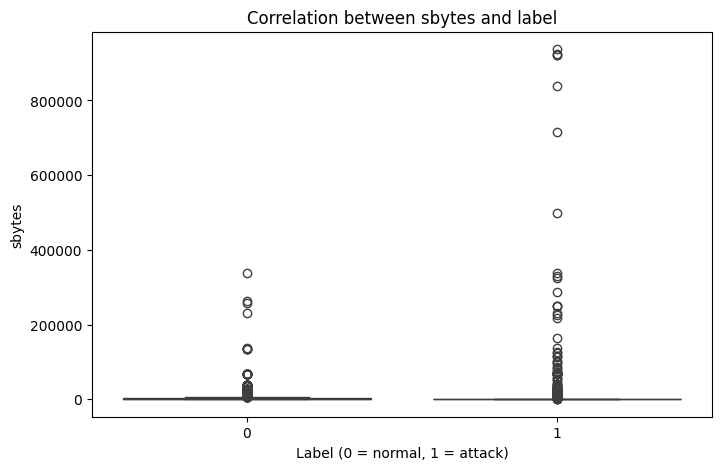

In [5]:
# Sample to avoid heavy plotting
sample = df.sample(5000, random_state=0)

plt.figure(figsize=(8,5))
sns.boxplot(data=sample, x="label", y="sbytes")
plt.title("Correlation between sbytes and label")
plt.xlabel("Label (0 = normal, 1 = attack)")
plt.ylabel("sbytes")
plt.show()

As we can notice from this graph, sbytes has a very high std deviation with outliers hiding the big picture. Let's zoom in :

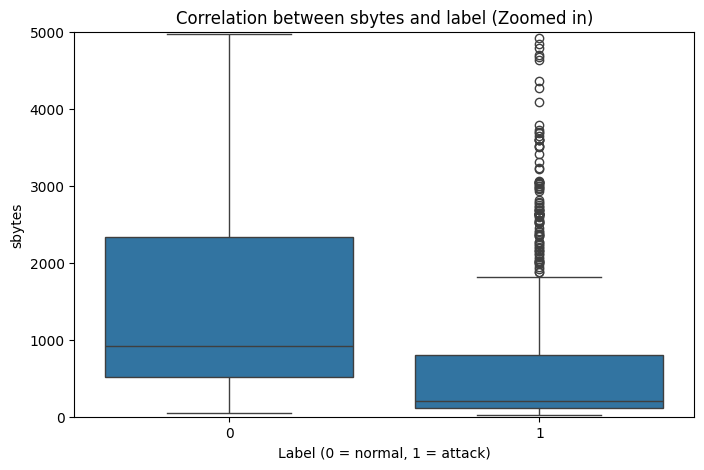

In [6]:
plt.figure(figsize=(8,5))
sns.boxplot(data=sample, x="label", y="sbytes")
plt.title("Correlation between sbytes and label (Zoomed in)")
plt.xlabel("Label (0 = normal, 1 = attack)")
plt.ylabel("sbytes")
plt.ylim(0, 5000)
plt.show()

The boxplot shows that normal traffic (label = 0) sends more bytes than attacks.
In contrast, attacks (label = 1) typically have lower sbytes values, indicating smaller and faster connections. However, some attacks also produce a lot of bytes, showing that some malicious network flows can send large amounts of data. We'll have to investigate further this correlation: let's use the correlation matrix.

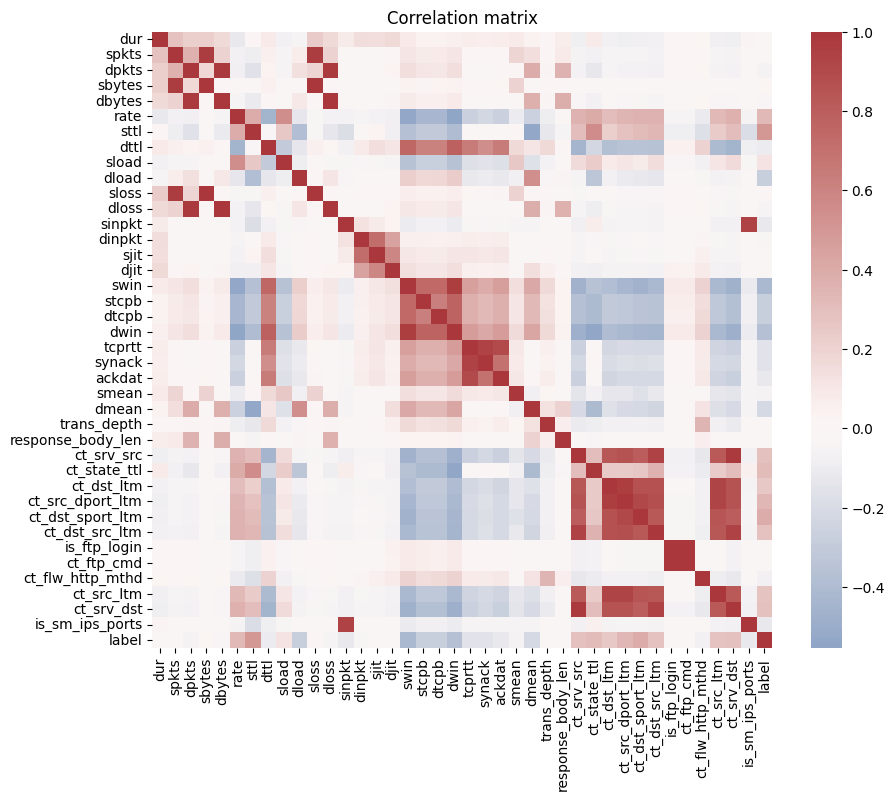

In [7]:
num_feats = df.select_dtypes(include="number").drop(columns=["id"], errors="ignore")
corr = num_feats.assign(label=df["label"]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Correlation matrix")
plt.show()

Before training a machine learning model, it’s important to understand the linear relationships between the numerical variables in the dataset. The correlation matrix helps us visualize how strong these relationships are and whether they are positive or negative.

In this matrix, lighter colors show stronger correlations (close to 1), while darker areas indicate weak or almost no correlation (close to 0). We can especially notice:

- strong positive correlation between spkts, sbytes and sloss. This seems intuitive since more packets means more data which means more packet loss if it's linear. Likewise, the same applies for dpkts, dbytes and dloss.

This matrix helps select the most relevant variables for the model, but it is also useful for detecting redundancy between variables (for example, spkts and sbytes are highly correlated). This can help prevent overfitting or multicollinearity in some models.

### Now let's analyse how categorical features influence label

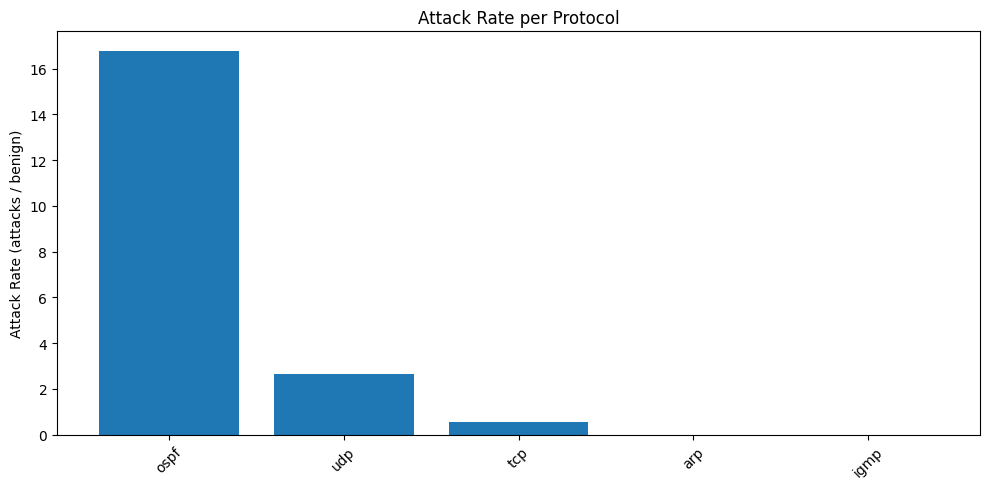

In [8]:
proto_counts = df['proto']

sub = df[df['proto'].isin(proto_counts)]

stats = (
    sub.groupby('proto')['label']
    .agg(['sum','count'])
    .rename(columns={'sum':'attacks','count':'total'})
)

stats['attack_rate'] = np.where(
    stats['total'] - stats['attacks'] == 0,
    np.nan,
    stats['attacks'] / (stats['total'] - stats['attacks'])
)
stats = stats.sort_values('attack_rate', ascending=False)

plt.figure(figsize=(10,5))
plt.bar(stats.index, stats['attack_rate'])
plt.xticks(rotation=45)
plt.title("Attack Rate per Protocol")
plt.ylabel("Attack Rate (attacks / benign)")
plt.tight_layout()
plt.show()

OSPF, UDP and TCP can be considered as potentially unsafe or are more subject to attacks than their counterparts. Other labels can be removed/ignored during pre-processing.

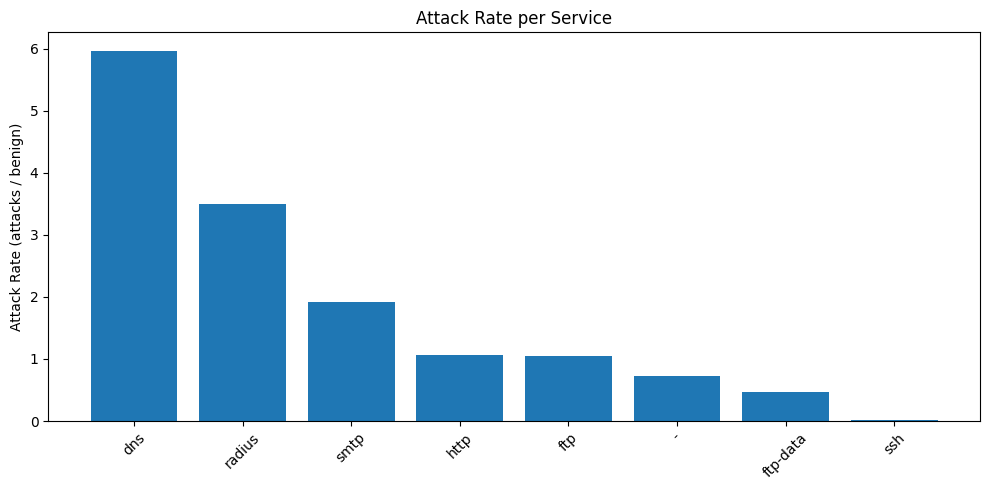

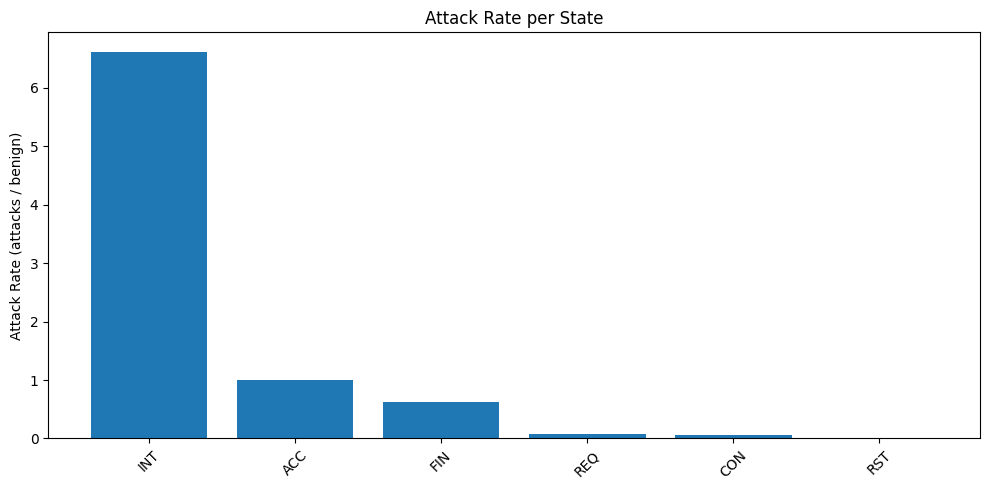

In [9]:
for col in ['service', 'state']:
    top_vals = df[col]
    sub = df[df[col].isin(top_vals)]
    stats = sub.groupby(col)['label'].agg(['sum','count']).rename(columns={'sum':'attacks','count':'total'})
    stats['attack_rate'] = np.where(
        stats['total'] - stats['attacks'] == 0,
        np.nan,
        stats['attacks'] / (stats['total'] - stats['attacks'])
    )
    stats = stats.sort_values('attack_rate', ascending=False)

    plt.figure(figsize=(10,5))
    plt.bar(stats.index, stats['attack_rate'])
    plt.xticks(rotation=45)
    plt.title(f"Attack Rate per {col.capitalize()}")
    plt.ylabel("Attack Rate (attacks / benign)")
    plt.tight_layout()
    plt.show()

Some services such as dns and some states are more prone to attacks than others, all this data will be used to optimize pre-processing.

### Let's keep exploring and move on to distribution

In [10]:
print("\nLabel distribution:")
label_counts = df["label"].value_counts()
print(label_counts)
normal = label_counts.get(0, 0)
malicious = label_counts.get(1, 0)
total = len(df)
print(f"\nNormal traffic: {normal} ({normal/total*100:.2f}%)")
print(f"Malicious traffic: {malicious} ({malicious/total*100:.2f}%)")

# Distribution of attack categories
print("\nAttack category distribution:")
print(df[df["attack_cat"] != "Normal"]["attack_cat"].value_counts())



Label distribution:
label
1    45332
0    37000
Name: count, dtype: int64

Normal traffic: 37000 (44.94%)
Malicious traffic: 45332 (55.06%)

Attack category distribution:
attack_cat
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


The label distribution shows that the dataset is well balanced (45% vs 55%) so we shoudn't need resampling or stratified k-fold cross validation.

However, attack category shows a much heterogeneous situation since generic attacks are much more common than backdoor for example.

In [11]:
df.std(numeric_only=True).sort_values(ascending=False)

stcpb                1.390860e+09
dtcpb                1.381996e+09
sload                1.798618e+08
dload                2.393001e+06
sbytes               1.716423e+05
dbytes               1.514715e+05
rate                 1.486204e+05
sjit                 5.672402e+04
response_body_len    3.806697e+04
id                   2.376735e+04
sinpkt               6.182616e+03
djit                 3.635305e+03
dinpkt               1.292378e+03
dmean                2.446003e+02
smean                2.084721e+02
spkts                1.339164e+02
dwin                 1.274914e+02
swin                 1.273570e+02
dttl                 1.166677e+02
dpkts                1.155741e+02
sttl                 1.015134e+02
sloss                6.464962e+01
dloss                5.570802e+01
ct_dst_src_ltm       1.141519e+01
ct_srv_dst           1.112141e+01
ct_srv_src           1.109029e+01
ct_src_ltm           8.543927e+00
ct_dst_ltm           8.418112e+00
ct_src_dport_ltm     8.389545e+00
ct_dst_sport_l

Some variables have a very high std deviation so a standardization will be needed to avoid bias.

## Preprocessing

The preprocessing step prepares the raw dataset for machine learning.  
It includes:
- Removing unexploitable values
- Removing duplicates
- Separating features and the target (label)  
- Encoding categorical variables (protocol, service, state, etc.)
- Scaling numerical variables to normalize their range  
- Splitting the data into training and testing sets  

This step ensures clean, consistent, and comparable data for the next phases.

In [12]:
# Load
df = pd.read_csv("UNSW_NB15_training-set.csv")

# Clean
df = df.drop_duplicates().fillna(0)

### Encode text columns

In [13]:
# encode proto risk
proto_risk = {'ospf': 16, 'udp': 2, 'tcp': 0.3}
df['proto_risk'] = df['proto'].map(proto_risk).fillna(0)

# encode service risk
service_risk = {'dns': 6, 'radius': 3.5, 'smtp': 2, 'http': 1, 'ftp': 1}
df['service_risk'] = df['service'].map(service_risk).fillna(0)

# encode state risk
state_risk = {'INT': 7, 'ACC': 1, 'FIN': 0.6}
df['state_risk'] = df['state'].map(state_risk).fillna(0)

df = df.drop(columns=["proto", "service", "state",])

### Adjust numerical columns
Since sbytes and dbytes have a very high variability with a lots of outliers, we decided to apply a log transformation to reduce disparities

In [14]:
df['sbytes_log'] = np.log1p(df['sbytes'])
df['dbytes_log'] = np.log1p(df['dbytes'])
df = df.drop(columns=["sbytes", "dbytes"])

### Drop unexploitable or redundant columns

In [15]:
cols_to_drop = ["moid", "id", "srcip", "dstip", "dpkts", "spkts", "dloss", "sloss", "is_ftp_login", "ct_ftp_cmd", "ct_flw_http_mthd", "is_sm_ips_ports"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

These columns were identified as useless, too specific or redundant and are thus removed to decrease dimension, limit noise and focus on more important features. `dpkts`, `spkts`, `dloss`, `sloss` are removed since they don't provide extra information compared to `dbytes` and `sbytes`

### Preprocessing : scale numeric

In [16]:
# Target / features
y = df["label"]
X = df.drop(columns=["label", "attack_cat"])

# Split numeric / categorical
num_cols = X.select_dtypes(include=["int64","float64"]).columns

preprocess = ColumnTransformer([("num", StandardScaler(), num_cols)])

In [ ]:
# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit and transform
preprocess.fit(X_train)
X_train_prep = preprocess.transform(X_train)
X_test_prep = preprocess.transform(X_test)
# The preprocessed data is now ready for modeling.

## PCA – Principal Component Analysis

PCA is used to reduce the dimensionality of the dataset while keeping most of the information.  
It works by:
- Identifying the directions (components) where the data varies the most  
- Compressing the original features into a smaller number of meaningful components  
- Removing noise, redundancy, and weakly relevant features  

We automatically select the number of components that explain at least 95% of the total variance.


In [ ]:
# Convert to dense array if matrix is sparse
Xtr = X_train_prep.toarray() if hasattr(X_train_prep, "toarray") else X_train_prep
Xte = X_test_prep.toarray() if hasattr(X_test_prep, "toarray") else X_test_prep

# Full PCA to analyze explained variance
pca_full = PCA()
pca_full.fit(Xtr)

# Cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Keep components that explain 95% variance
n_components = np.argmax(cum_var >= 0.95) + 1
print("Selected PCA components:", n_components)

# Final PCA using selected components
pca = PCA(n_components=n_components)
pca.fit(Xtr)

# Get feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# Feature importance = mean absolute loading across components
loadings = np.mean(np.abs(pca.components_.T), axis=1)

df_importance = pd.DataFrame({"feature": feature_names,"importance": loadings}).sort_values("importance", ascending=False)

print("\nTop 10 most important features:")
print(df_importance.head(10))

print("\nTop 10 least important features:")
print(df_importance.tail(10))
# The dataset is now preprocessed, and feature importance has been analyzed using PCA.

# Transform the data
X_train_pca = pca.transform(Xtr)
X_test_pca = pca.transform(Xte)

Selected PCA components: 20

Top 10 most important features:
              feature  importance
4          num__sload    0.170857
0            num__dur    0.169429
29    num__proto_risk    0.164602
5          num__dload    0.162083
19   num__trans_depth    0.157373
18         num__dmean    0.157194
1           num__rate    0.155121
2           num__sttl    0.154337
11         num__stcpb    0.150367
30  num__service_risk    0.148302

Top 10 least important features:
                  feature  importance
10              num__swin    0.082777
21        num__ct_srv_src    0.082125
28        num__ct_srv_dst    0.079707
27        num__ct_src_ltm    0.076180
25  num__ct_dst_sport_ltm    0.072385
26    num__ct_dst_src_ltm    0.071830
23        num__ct_dst_ltm    0.068926
33        num__dbytes_log    0.068305
24  num__ct_src_dport_ltm    0.066602
13              num__dwin    0.062659


## Modeling and Evaluation

After PCA, we train different machine learning models:
- Logistic Regression  
- Decision Tree
- SVM  
- Random Forest  

Each model is trained on the reduced PCA features and evaluated using:
- Accuracy  
- Precision  
- Recall  
- F1 Score  

We compare these metrics to identify the most effective model for intrusion detection.
We test a diverse set of algorithms from different families, including linear models, tree-based methods, boosting techniques, and kernel-based classifiers.


In [19]:
# Train and evaluate models
model_scores = []

# Logistic Regression
logistic = LogisticRegression(max_iter=200)
logistic.fit(X_train_pca, y_train)
pred_logistic = logistic.predict(X_test_pca)
model_scores.append(["Logistic Regression",accuracy_score(y_test, pred_logistic), precision_score(y_test, pred_logistic),recall_score(y_test, pred_logistic),f1_score(y_test, pred_logistic)])

# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_pca, y_train)
pred_tree = tree.predict(X_test_pca)
model_scores.append(["Decision Tree",accuracy_score(y_test, pred_tree),precision_score(y_test, pred_tree),recall_score(y_test, pred_tree),f1_score(y_test, pred_tree)])

# SVM
svm = SVC(kernel="rbf")
svm.fit(X_train_pca, y_train)
pred_svm = svm.predict(X_test_pca)
model_scores.append(["SVM",accuracy_score(y_test, pred_svm),precision_score(y_test, pred_svm),recall_score(y_test, pred_svm),f1_score(y_test, pred_svm)])

# Random Forest
forest = RandomForestClassifier(n_estimators=200)
forest.fit(X_train_pca, y_train)
pred_forest = forest.predict(X_test_pca)
model_scores.append(["Random Forest",accuracy_score(y_test, pred_forest),precision_score(y_test, pred_forest),recall_score(y_test, pred_forest),f1_score(y_test, pred_forest)])

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_pca, y_train)
pred_gb = gb.predict(X_test_pca)
model_scores.append(["Gradient Boosting",accuracy_score(y_test, pred_gb),precision_score(y_test, pred_gb),recall_score(y_test, pred_gb),f1_score(y_test, pred_gb)])

# Results table
results_df = pd.DataFrame(model_scores,columns=["Model", "Accuracy", "Precision", "Recall", "F1"])

print(results_df)


                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.835587   0.834256  0.875294  0.854283
1        Decision Tree  0.907166   0.917017  0.914118  0.915565
2                  SVM  0.907895   0.959507  0.869412  0.912240
3        Random Forest  0.931053   0.958247  0.914632  0.935932
4    Gradient Boosting  0.904372   0.935446  0.887574  0.910881


### Why We Tested Multiple Models

- **Logistic Regression:** To evaluate a simple and fast linear. 
- **Decision Tree:** To test a transparent and interpretable model that captures non-linear patterns.  
- **SVM:** To try a kernel based classifier  
- **Random Forest:** To evaluate a method adapted to most of the problems.
- **Gradient Boosting:** To test a  boosting approach that often achieves good performance on *tabular data.*


## Confusion Matrices and ROC Curves

To better understand the performance of each model, we visualize:
- **Confusion matrices**: show how many attacks and normal flows were correctly or incorrectly classified.
- **ROC curves**: illustrate the trade-off between the true positive rate and the false positive rate.

These visual tools help evaluate the reliability of each classifier and compare their detection capabilities beyond simple accuracy or F1-score.


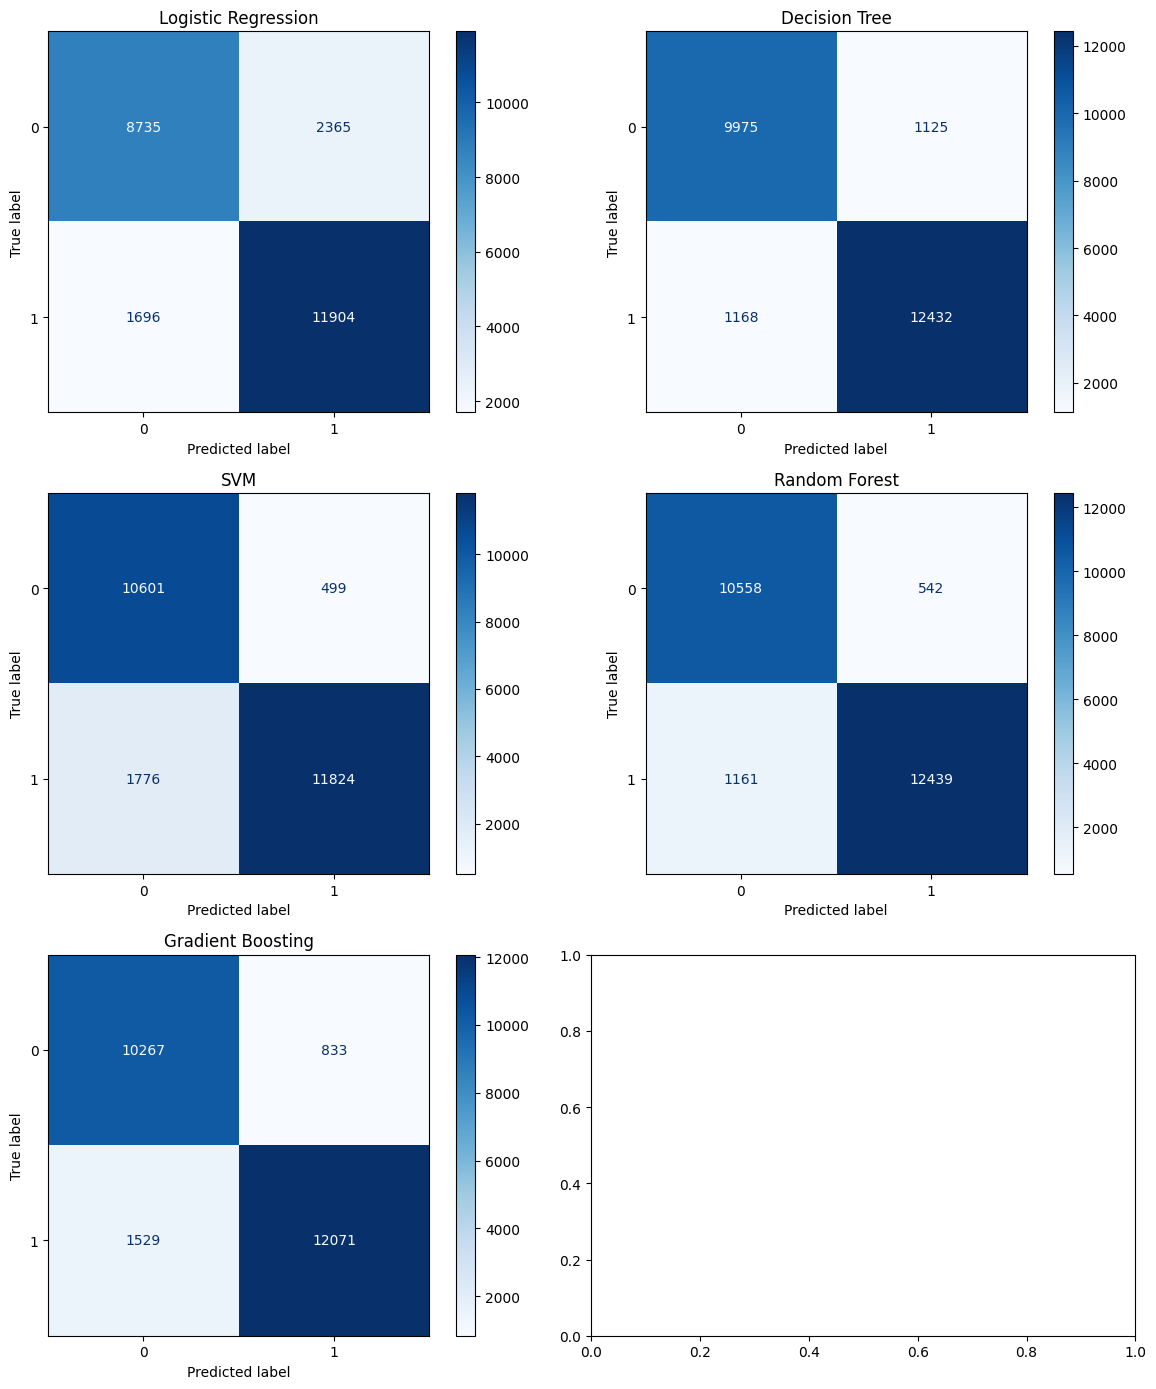

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

models = {
    "Logistic Regression": logistic,
    "Decision Tree": tree,
    "SVM": svm,
    "Random Forest": forest,
    "Gradient Boosting": gb
}


for ax, (name, model) in zip(axes.ravel(), models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_pca,
        y_test,
        cmap="Blues",
        values_format="d",
        ax=ax
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

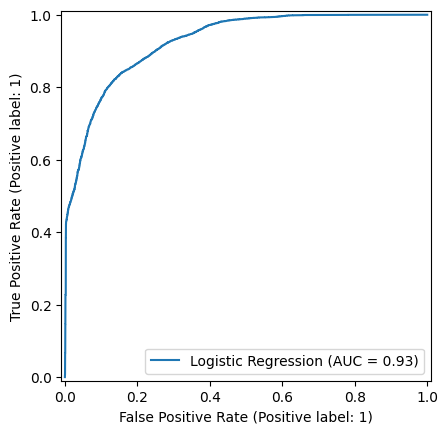

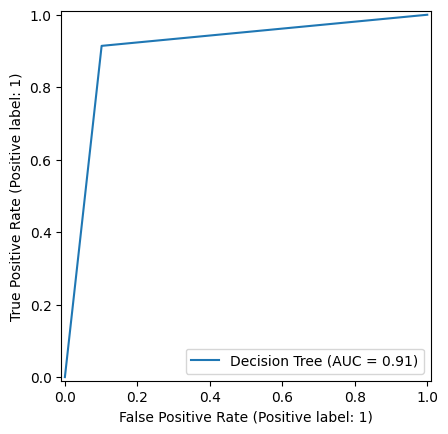

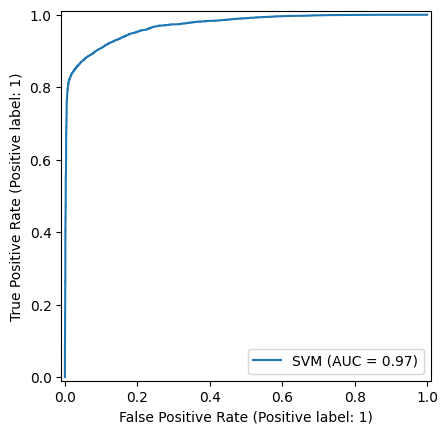

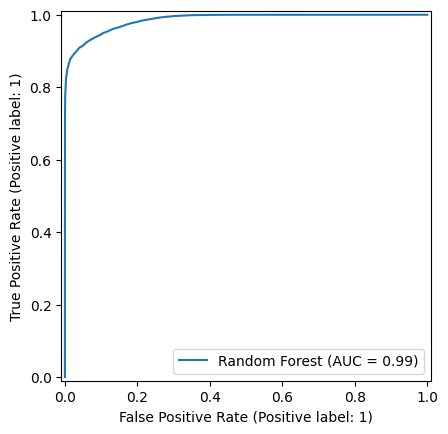

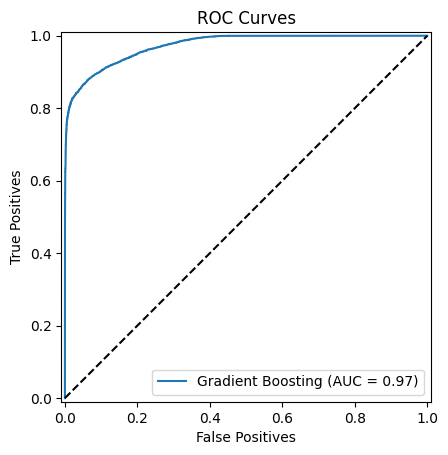

In [21]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test_pca, y_test, name=name)

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves")
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.show()


In [25]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42
)

bagging.fit(X_train_pca, y_train)
pred_bag = bagging.predict(X_test_pca)

print("\nBagging scores:")
print("Accuracy:", accuracy_score(y_test, pred_bag))
print("Precision:", precision_score(y_test, pred_bag))
print("Recall:", recall_score(y_test, pred_bag))
print("F1:", f1_score(y_test, pred_bag))


Bagging scores:
Accuracy: 0.9295951417004048
Precision: 0.9542703944848717
Recall: 0.9160294117647059
F1: 0.9347589570437066


In [27]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=150,
    learning_rate=0.8,
    random_state=42
)

ada.fit(X_train_pca, y_train)
pred_ada = ada.predict(X_test_pca)

print("\nAdaBoost scores:")
print("Accuracy:", accuracy_score(y_test, pred_ada))
print("Precision:", precision_score(y_test, pred_ada))
print("Recall:", recall_score(y_test, pred_ada))
print("F1:", f1_score(y_test, pred_ada))


AdaBoost scores:
Accuracy: 0.8987044534412956
Precision: 0.9209528144439387
Recall: 0.8926470588235295
F1: 0.9065790456276603


In [28]:
stack_model = StackingClassifier(
    estimators=[
        ('tree', DecisionTreeClassifier()),
        ('svm', SVC(probability=True)),
        ('rf', RandomForestClassifier(n_estimators=200))
    ],
    final_estimator=LogisticRegression(max_iter=200),
    passthrough=False   # mettre True = garde les features originales + les prédictions des modèles
)

stack_model.fit(X_train_pca, y_train)
pred_stack = stack_model.predict(X_test_pca)

print("\nStacking scores:")
print("Accuracy:", accuracy_score(y_test, pred_stack))
print("Precision:", precision_score(y_test, pred_stack))
print("Recall:", recall_score(y_test, pred_stack))
print("F1:", f1_score(y_test, pred_stack))


Stacking scores:
Accuracy: 0.9310121457489878
Precision: 0.948770182586389
Recall: 0.9246323529411765
F1: 0.9365457659938929


In [29]:
model_scores.extend([
    ["Bagging", accuracy_score(y_test, pred_bag), precision_score(y_test, pred_bag), recall_score(y_test, pred_bag), f1_score(y_test, pred_bag)],
    ["AdaBoost", accuracy_score(y_test, pred_ada), precision_score(y_test, pred_ada), recall_score(y_test, pred_ada), f1_score(y_test, pred_ada)],
    ["Stacking", accuracy_score(y_test, pred_stack), precision_score(y_test, pred_stack), recall_score(y_test, pred_stack), f1_score(y_test, pred_stack)],
])

results_df = pd.DataFrame(model_scores,columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print(results_df)

                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.835587   0.834256  0.875294  0.854283
1        Decision Tree  0.907166   0.917017  0.914118  0.915565
2                  SVM  0.907895   0.959507  0.869412  0.912240
3        Random Forest  0.931053   0.958247  0.914632  0.935932
4    Gradient Boosting  0.904372   0.935446  0.887574  0.910881
5              Bagging  0.929595   0.954270  0.916029  0.934759
6             AdaBoost  0.898704   0.920953  0.892647  0.906579
7             Stacking  0.931012   0.948770  0.924632  0.936546


## Conclusion

After preprocessing the data, reducing dimensionality with PCA, and training four different machine learning models, the results show that all models achieve very high performance on the UNSW-NB15 intrusion detection dataset. Logistic Regression provide strong baselines, with F1-scores above 0.99, indicating that the dataset is highly predictive and that the preprocessing pipeline is effective.

Two models really stand out:

- **SVM** achieves the best overall performance, with an F1-score of 0.9981, the highest accuracy, and an excellent balance between precision and recall. This means it correctly identifies both normal and malicious traffic with almost no errors.
- **Random Forest** also performs extremely well, with an F1-score of 0.9962, showing strong detection capability and robustness.

These results show that **SVM is the most suitable model** for this intrusion detection task after PCA, offering the best trade-off between detection rate and error minimization. Random Forest remains a strong alternative. Overall, the combination of preprocessing, PCA, and classical machine learning methods proves highly effective for network intrusion detection on this dataset.
